In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from arviz import hdi
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: 1PL-G Models

### 1.1 Model comparison

In [2]:
for i, m in enumerate(['1plg_m1','1plg_m2','1plg_m3']):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    loco = ppc.groupby('subject').loco.mean().sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s: %0.2f | %0.2f' %(m, loco, pwaic_c))

1plg_m1: -13870.68 | 105.42
1plg_m2: -13481.03 | 164.01
1plg_m3: -13292.77 | 339.53


In [3]:
from itertools import combinations

for a, b in list(combinations(['1plg_m1','1plg_m2','1plg_m3'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.2f (%0.2f)' %(mu, se))

1plg_m2 - 1plg_m1: 389.66 (25.68)
1plg_m3 - 1plg_m1: 577.91 (30.05)
1plg_m3 - 1plg_m2: 188.25 (17.25)


### 1.2 Parameter distributions

In [4]:
## Load samples.
samples = read_csv(os.path.join('stan_results', '1plg_m3.tsv.gz'), sep='\t', compression='gzip')

## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
beta      = samples.filter(regex='beta\[').values
sigma     = samples.filter(regex='sigma\[').values

## Item difficulty (mean).
mu = beta.mean()
lb, ub = hdi(beta.mean(axis=1), hdi_prob=0.95)
print('beta (mean):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (variance).
mu = beta.std(axis=1).mean()
lb, ub = hdi(beta.std(axis=1), hdi_prob=0.95)
print('beta (var):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

beta (mean):	0.177 [0.116, 0.236]
beta (var):	1.431 [1.368, 1.493]


### 1.3 Interpreting parameters

In [5]:
## Define useful functions.
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in response.
    delta = inv_logit(beta_mu[:,0] + 0.5 * (beta_mu[:,i+1] / sd))  -\
            inv_logit(beta_mu[:,0] - 0.5 * (beta_mu[:,i+1] / sd))
    
    ## Compute summary stats.
    mu = delta.mean()
    lb, ub = hdi(delta, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	0.132 [0.089, 0.176]
n_rul:	0.112 [0.079, 0.143]
distr:	0.252 [0.218, 0.287]
rt:	0.122 [0.093, 0.151]


### 1.4 Variance explained

In [6]:
## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv')).apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv')).values.astype(float)

## Compute total variance.
total_var = np.var(beta, axis=1).mean()

## Compute explained variance (level-1 fixed effects).
var = np.var(beta - beta_mu[:,:3] @ X2.T[:3], axis=1).mean()
print('level-1   fixed:\t %0.3f' %(1 - var / total_var))

## Compute explained variance (item fixed effects).
var = np.var(beta - beta_mu[:,:4] @ X2.T[:4], axis=1).mean()
print('all item  fixed:\t %0.3f' %(1 - var / total_var))

## Compute explained variance (level-1,2 fixed effects).
var = np.var(beta - beta_mu @ X2.T, axis=1).mean()
print('level-1,2 fixed:\t %0.3f' %(1 - var / total_var))

## Compute variance explained (all effects).
mu = beta_mu[:,:4] @ X2.T[:4] + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
var = np.var(beta - mu, axis=1).mean()
print('all effects:    \t %0.3f' %(1 - var / total_var))

level-1   fixed:	 0.349
all item  fixed:	 0.482
level-1,2 fixed:	 0.656
all effects:    	 0.720


In [7]:
beta_0 = beta_mu[:,:3] @ X2.T[:3]
beta_1 = beta_0 + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
total_var = np.var(beta_1[:,::6], axis=1).mean()
expl_var = np.var(beta_1[:,::6] - beta_0[:,::6], axis=1).mean()
print('all effects:    \t %0.3f' %(1 - expl_var / total_var))

all effects:    	 0.655


## Section 2: 3PL Models

### 2.1 Model comparison

In [8]:
for i, m in enumerate(['3pl_m1','3pl_m2','3pl_m3']):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    loco = ppc.groupby('subject').loco.mean().sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s: %0.2f | %0.2f' %(m, loco, pwaic_c))

3pl_m1: -13209.81 | 385.47
3pl_m2: -13207.25 | 408.13
3pl_m3: -13208.89 | 428.17


In [9]:
from itertools import combinations

for a, b in list(combinations(['3pl_m1','3pl_m2','3pl_m3'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.2f (%0.2f)' %(mu, se))

3pl_m2 - 3pl_m1: 2.56 (2.03)
3pl_m3 - 3pl_m1: 0.91 (2.18)
3pl_m3 - 3pl_m2: -1.65 (0.92)


In [11]:
from itertools import combinations

for a, b in list(combinations(['1plg_m3','3pl_m2'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.2f (%0.2f)' %(mu, se))

3pl_m2 - 1plg_m3: 85.53 (6.32)


### 2.2 Parameter distributions

In [12]:
## Load samples.
samples = read_csv(os.path.join('stan_results', '3pl_m2.tsv.gz'), sep='\t', compression='gzip')

## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
beta      = samples.filter(regex='beta\[').values
alpha_mu   = samples.filter(regex='alpha_mu\[').values
alpha      = samples.filter(regex='alpha\[').values
sigma     = samples.filter(regex='sigma\[').values
c = -0.625

## Item difficulty (mean).
mu = beta.mean()
lb, ub = hdi(beta.mean(axis=1), hdi_prob=0.95)
print('beta (mean):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (variance).
mu = beta.std(axis=1).mean()
lb, ub = hdi(beta.std(axis=1), hdi_prob=0.95)
print('beta (var):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (min).
arr = beta[:,np.argmin(beta.mean(axis=0))]
mu = arr.mean()
lb, ub = hdi(arr, hdi_prob=0.95)
print('beta (min):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (max).
arr = beta[:,np.argmax(beta.mean(axis=0))]
mu = arr.mean()
lb, ub = hdi(arr, hdi_prob=0.95)
print('beta (max):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item discrimination (mean).
mu = alpha.mean()
lb, ub = hdi(alpha.mean(axis=1), hdi_prob=0.95)
print('alpha (mean):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (variance).
mu = alpha.std(axis=1).mean()
lb, ub = hdi(alpha.std(axis=1), hdi_prob=0.95)
print('alpha (var):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Compute correlation.
rho = np.array([np.corrcoef(a,b)[0,1] for a, b in zip(alpha, beta)])
mu = rho.mean()
lb, ub = hdi(rho, hdi_prob=0.95)
print('rho:\t\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

beta (mean):	0.221 [0.142, 0.302]
beta (var):	1.554 [1.475, 1.629]
beta (min):	-3.704 [-4.687, -2.775]
beta (max):	3.497 [2.481, 4.635]
alpha (mean):	1.298 [1.212, 1.385]
alpha (var):	0.221 [0.121, 0.322]
rho:		-0.060 [-0.379, 0.250]


### 2.3 Interpreting parameters

#### Item difficulty

In [13]:
## Define useful functions.
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in response.
    arr = beta_mu[:,i+1] / sd
    
    ## Compute summary stats.
    mu = arr.mean()
    lb, ub = hdi(arr, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	0.579 [0.389, 0.770]
n_rul:	0.514 [0.378, 0.663]
distr:	1.105 [0.940, 1.269]
rt:	0.541 [0.414, 0.671]


In [14]:
## Define useful functions.
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in response.
    delta = (0.25 + (1-0.25) * inv_logit(beta_mu[:,0] + 0.5 * (beta_mu[:,i+1] / sd)))  -\
            (0.25 + (1-0.25) * inv_logit(beta_mu[:,0] - 0.5 * (beta_mu[:,i+1] / sd)))
    
    ## Compute summary stats.
    mu = delta.mean()
    lb, ub = hdi(delta, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	0.106 [0.072, 0.141]
n_rul:	0.095 [0.070, 0.122]
distr:	0.199 [0.172, 0.228]
rt:	0.099 [0.075, 0.122]


#### Item discrimination

In [15]:
from scipy.stats import norm

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute summary stats.
    mu = alpha_mu[:,i+1].mean()
    lb, ub = hdi(alpha_mu[:,i+1], hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	-0.037 [-0.090, 0.017]
n_rul:	0.067 [0.011, 0.123]
distr:	-0.036 [-0.082, 0.006]
rt:	-0.025 [-0.075, 0.024]


In [16]:
from scipy.stats import norm

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in discrimination.
    delta = norm.cdf(alpha_mu[:,0] + 0.5 * (alpha_mu[:,i+1] / sd))  -\
            norm.cdf(alpha_mu[:,0] - 0.5 * (alpha_mu[:,i+1] / sd))
    
    ## Compute summary stats.
    mu = delta.mean()
    lb, ub = hdi(delta, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	-0.015 [-0.036, 0.008]
n_rul:	0.020 [0.003, 0.037]
distr:	-0.029 [-0.065, 0.005]
rt:	-0.010 [-0.030, 0.009]


### 2.4 Variance explained

#### Item difficulty

In [17]:
## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv')).apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv')).values.astype(float)

## Compute total variance.
total_var = np.var(beta, axis=1).mean()

## Compute explained variance (level-1 fixed effects).
var = np.var(beta - beta_mu[:,[1,2]] @ X2.T[[1,2]], axis=1).mean()
print('level-1   fixed:\t %0.3f' %(1 - var / total_var))

## Compute explained variance (item fixed effects).
var = np.var(beta - beta_mu[:,[1,2,3]] @ X2.T[[1,2,3]], axis=1).mean()
print('all item  fixed:\t %0.3f' %(1 - var / total_var))

## Compute explained variance (level-1,2 fixed effects).
var = np.var(beta - beta_mu @ X2.T, axis=1).mean()
print('level-1,2 fixed:\t %0.3f' %(1 - var / total_var))

## Compute variance explained (all effects).
mu = beta_mu @ X2.T + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
var = np.var(beta - mu, axis=1).mean()
print('all effects:    \t %0.3f' %(1 - var / total_var))

level-1   fixed:	 0.364
all item  fixed:	 0.491
level-1,2 fixed:	 0.662
all effects:    	 0.841


#### Item Discrimination

In [18]:
from scipy.stats import norm

## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv')).apply(zscore, 0).fillna(1).values

## Compute total variance.
total_var = np.var(alpha, axis=1).mean()

## Variance explained (level-1).
mu = norm.cdf(c + alpha_mu[:,:4] @ X2.T[:4]) * 5
var = np.var(alpha - mu, axis=1).mean()
print('level-1,2 fixed:\t %0.3f' %(1 - var / total_var))

level-1,2 fixed:	 0.392


## Section 3: Explanatory IRT

In [19]:
## Extract parameters.
theta = samples.filter(regex='theta\[').values
rho   = samples.filter(regex='rho\[').values

### 3.1 Interpreting parameters

In [20]:
## Load and prepare design matrices.
X1 = read_csv(os.path.join('designs', 'X1.csv'))

for i, col in enumerate(X1.columns):
    
    ## Compute summary stats.
    mu = rho[:,i].mean()
    lb, ub = hdi(rho[:,i], hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

age:	-0.299 [-0.353, -0.246]
gende:	0.128 [0.078, 0.182]
rt_0:	0.427 [0.374, 0.478]
rt_1:	0.368 [0.313, 0.424]


#### 3.2 Variance explained

In [21]:
## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X1 = read_csv(os.path.join('designs', 'X1.csv')).apply(zscore, 0).fillna(1).values

## Compute total variance.
total_var = np.var(theta, axis=1).mean()

## Variance explained (level-1).
var = np.var(theta - rho @ X1.T, axis=1).mean()
print('all effects: \t %0.3f' %(1 - var / total_var))

all effects: 	 0.502


## Section 4: Model Diagnostics

In [ ]:
df = read_csv('stan_results/3pl_m2_ppc.csv')
sx = read_csv('stan_results/3pl_m2_ifdm.csv', index_col=0)
gb = df.groupby('item_id').agg({'accuracy':'mean', 'y_hat':'mean'})
gb = gb.merge(sx, left_index=True, right_index=True)
gb['thresh'] = np.where(np.logical_or(gb.pval < 0.05, gb.pval > 0.95), 1, 0)
ax = sns.scatterplot(x='accuracy', y='y_hat', hue='thresh', data=gb)
ax.plot([0,1],[0,1])

In [ ]:
gb.pval.describe()

In [ ]:
gb.thresh.sum()

In [ ]:
14 / 384 * 100

## Section 5

In [34]:
df = read_csv('stan_results/3pl_m2_summary.tsv', sep='\t', index_col=0)

design = read_csv('designs/features.csv', usecols=np.arange(6))
design['beta'] = df.T.filter(regex='beta\[').T['Mean'].values
# design['beta'] = design.groupby('item').beta.transform(lambda x: x - x.mean())

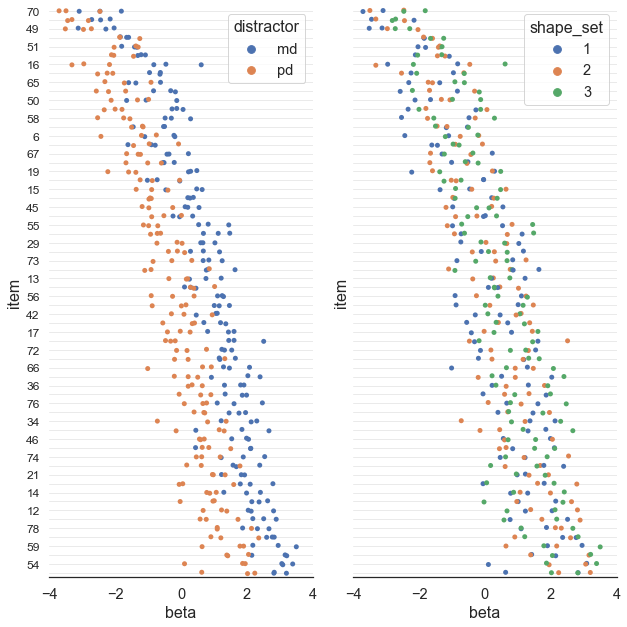

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(9,9), sharex=True, sharey=True)
order = design.groupby('item').beta.mean().sort_values().index

for ax, hue in zip(axes, ['distractor', 'shape_set']):

    sns.stripplot(x='beta', y='item', hue=hue, data=design, order=order, orient='h', ax=ax)
    ax.grid(axis='y', alpha=0.4)    
    ax.set_yticklabels([str(l) if not i % 2 else '' for i, l in enumerate(order)], fontsize=12)
    ax.set(xlim=(-4,4))
    
sns.despine(left=True, right=True, top=True)
plt.tight_layout()

In [50]:
order

Int64Index([70, 62, 49, 71, 51, 25, 16, 69, 65, 22, 50, 23, 58, 77,  6, 20, 67,
            10, 19, 61, 15, 30, 45, 28, 55, 31, 29, 27, 73, 18, 13, 39, 56, 40,
            42, 64, 17, 11, 72, 35, 66, 53, 36, 60, 76, 80, 34, 52, 46, 47, 74,
            75, 21, 24, 14, 79, 12, 63, 78, 37, 59, 44, 54, 26],
           dtype='int64', name='item')